# Variant distribtion per chromosome

This notebook aims to understand the distribution of variantIndex and credibleSet dataset variants across chromosomes.
VariantIndex contains variants that have well known associations to traits or come from GWAS credible sets

## Setup

In [2]:
# Ensure proper java version < 11
!java -version


openjdk version "11.0.13" 2021-10-19
OpenJDK Runtime Environment JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21)
OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)


In [35]:
!rsync -rpltvz --delete rsync.ebi.ac.uk::pub/databases/opentargets/platform/25.03/output/variant ../../data/.
!rsync -rpltvz --delete rsync.ebi.ac.uk::pub/databases/opentargets/platform/25.03/output/credible_set ../../data/.


receiving incremental file list

sent 29 bytes  received 1.771 bytes  3.600,00 bytes/sec
total size is 3.060.963.047  speedup is 1.700.535,03
receiving incremental file list

sent 29 bytes  received 1.770 bytes  3.598,00 bytes/sec
total size is 2.371.305.976  speedup is 1.318.124,50


In [59]:
from __future__ import annotations

import re
from enum import StrEnum

import requests
import seaborn as sns
from gentropy.common.session import Session
from gentropy.dataset.study_locus import StudyLocus
from gentropy.dataset.variant_index import VariantIndex
from matplotlib import pyplot as plt
from pyspark.sql import Column
from pyspark.sql import functions as f


In [41]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
variant_index_path = "../../data/variant"
credible_set_path = "../../data/credible_set"


25/04/25 11:25:41 WARN Utils: Your hostname, mindos resolves to a loopback address: 127.0.1.1; using 192.168.0.100 instead (on interface eno1)
25/04/25 11:25:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/25 11:25:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [42]:
session.spark


In [60]:
sns.set_style("white")
sns.set_context("paper", font_scale=0.0)
sns.set_palette(sns.color_palette("coolwarm"))


In [61]:
### Extract chromosome lenghts


class Chromosome:
    __match_args__ = ("name", "length", "order")

    arbitrary_order = {str(name): idx for name, idx in zip(list(range(1, 23)) + ["X", "Y", "MT"], list(range(1, 26)))}

    class ChromosomeNotationType(StrEnum):
        """Chromosome notation type."""

        ENSEMBL = r"^(\d{1}|[12]{1}\d{1}|[XY]{1}|MT{1})$"
        UCSC = r"^(chr(\d{1}|[12]{1}\d{1}|[XYM]{1}))$"

    def __init__(self, name: str, length: int):
        self.length = length

        for not_type in self.ChromosomeNotationType:
            pattern = re.compile(not_type.value)
            _match = pattern.match(name)
            match _match:
                case re.Match():
                    match not_type:
                        case self.ChromosomeNotationType.UCSC:
                            self.name = self.ucsc_to_ensemb(name)
                        case self.ChromosomeNotationType.ENSEMBL:
                            self.name = name
                    self.order = self.arbitrary_order.get(self.name)
                    break
                case _:
                    self.name = None
                    self.order = None
        if not self.name:
            raise ValueError(f"Encountered non-canonical chromosome name {name}")

    @staticmethod
    def ucsc_to_ensemb(name: str) -> str:
        """Convert ucsc name to ensembl for canonical chromosomes."""
        return name.lower().removeprefix("chr").replace("m", "mt").upper()

    def __eq__(self, other: Chromosome) -> bool:
        return self.order == other.order

    def __lt__(self, other: Chromosome) -> bool:
        return self.order < other.order

    def __gt__(self, other: Chromosome) -> bool:
        return self.order > other.order

    def __repr__(self) -> str:
        return f"Chromosome(name={self.name}, length={self.length})"


chromosomes = [str(c) for c in range(1, 23)] + ["X", "Y", "MT"]
order = {c: idx for idx, c in enumerate(chromosomes)}


def sort_by_chromosome(col: Column) -> Column:
    """Sort by chromosome."""
    expr = f.when(f.lit(False), None)
    for chromosome_name, chromosome_index in order.items():
        expr = expr.when(col == chromosome_name, f.lit(chromosome_index))
    return expr.alias("chromosomeIndex")


## Data loading

In [43]:
vi = VariantIndex.from_parquet(session, variant_index_path)
cs = StudyLocus.from_parquet(session, credible_set_path)


### Extracting chromosome lengths

In [ ]:
species = "homo_sapiens"  # Change to desired species
url = f"https://rest.ensembl.org/info/assembly/{species}?content-type=application/json"

response = requests.get(url, headers={"Content-Type": "application/json"})
data = response.json()

chromosomes = [str(i) for i in range(1, 23)] + ["X", "Y", "MT"]
chr_lenghts: list[Chromosome] = []
for chrom in data["top_level_region"]:
    if chrom["coord_system"] == "chromosome":
        if chrom["name"] in chromosomes:
            c = Chromosome(chrom["name"], chrom["length"])
            chr_lenghts.append(c)

chromosome_lenghts = session.spark.createDataFrame([(c.name, c.length) for c in chr_lenghts], ["chromosome", "len"])


### Calculating variant counts

* count - total number of unique variants in chromosome
* % - percent of entire chromosome length captured by variant count (can be imprecise due to the fact that multiple variants can capture the same position)

In [70]:
vi_chromosome_variants = (
    vi.df.groupBy("chromosome")
    .count()
    .withColumn("chromosomeIndex", sort_by_chromosome(f.col("chromosome")))
    .join(chromosome_lenghts, on="chromosome")
    .withColumn("%", f.col("count") / f.col("len") * f.lit(100))
    .orderBy("chromosomeIndex")
)
cs_chromosome_variants = (
    cs.df.select("variantId", "chromosome")
    .distinct()
    .groupBy("chromosome")
    .count()
    .withColumn("chromosomeIndex", sort_by_chromosome(f.col("chromosome")))
    .join(chromosome_lenghts, on="chromosome")
    .withColumn("%", f.col("count") / f.col("len") * f.lit(100))
    .orderBy("chromosomeIndex")
)


In [71]:
vi_chromosome_variants.show(truncate=False, n=30)


+----------+------+---------------+---------+---------------------+
|chromosome|count |chromosomeIndex|len      |%                    |
+----------+------+---------------+---------+---------------------+
|1         |555116|0              |248956422|0.22297717630276678  |
|2         |574342|1              |242193529|0.23714176112442706  |
|3         |410428|2              |198295559|0.20697790816384345  |
|4         |334152|3              |190214555|0.1756710994066674   |
|5         |367694|4              |181538259|0.20254353105810052  |
|6         |344861|5              |170805979|0.20190218282698405  |
|7         |361729|6              |159345973|0.22700856079996448  |
|8         |276396|7              |145138636|0.19043585334507346  |
|9         |263790|8              |138394717|0.19060698682594943  |
|10        |287524|9              |133797422|0.21489502241679964  |
|11        |356345|10             |135086622|0.2637899998713418   |
|12        |316971|11             |133275309|0.2

In [69]:
cs_chromosome_variants.show(truncate=False, n=30)


+----------+-----+---------------+---------+--------------------+
|chromosome|count|chromosomeIndex|len      |%                   |
+----------+-----+---------------+---------+--------------------+
|1         |84058|0              |248956422|0.03376414206338489 |
|2         |71176|1              |242193529|0.029388068415320875|
|3         |53814|2              |198295559|0.027138277968191914|
|4         |42214|3              |190214555|0.022192833771316818|
|5         |46432|4              |181538259|0.025576977688212817|
|6         |42653|5              |170805979|0.024971608283103488|
|7         |50003|6              |159345973|0.03138014664481041 |
|8         |37283|7              |145138636|0.02568785337075925 |
|9         |34893|8              |138394717|0.025212667619386075|
|10        |41318|9              |133797422|0.03088101353701718 |
|11        |49618|10             |135086622|0.03673050614886202 |
|12        |47081|11             |133275309|0.03532612331065764 |
|13       

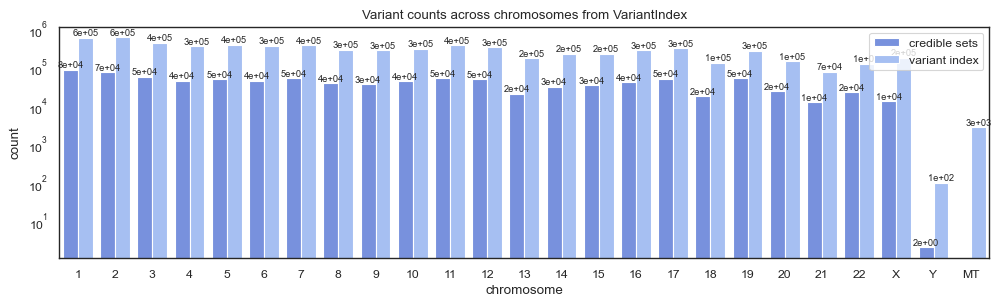

In [49]:
palette = ["#3A0CA3", "#4361EE", "#4CC9F0"]

dataset = (
    vi_chromosome_variants.select("chromosome", f.col("count").alias("viCount"), "chromosomeIndex")
    .join(
        cs_chromosome_variants.select("chromosome", f.col("count").alias("csCount")),
        how="left",
        on="chromosome",
    )
    .fillna(0)
    .toPandas()
    .melt(
        id_vars=["chromosome", "chromosomeIndex"],
        value_vars=["viCount", "csCount"],
        var_name="source",
        value_name="count",
    )
    .sort_values(by=["chromosomeIndex", "source"])
)
fig = plt.figure(figsize=(12, 3))
ax = plt.subplot(1, 1, 1)
bar1 = sns.barplot(dataset, x="chromosome", y="count", hue="source", ax=ax)
bar1.set_title("Variant counts across chromosomes from VariantIndex")


bar1.set_yscale("log")
handles, labels = bar1.get_legend_handles_labels()
for container in ax.containers:
    ax.bar_label(container, fmt=lambda x: f"{x:.0e}", fontsize="x-small")

bar1.legend(handles, ["credible sets", "variant index"])
